<a href="https://colab.research.google.com/github/Hanifanta/Sentiment-Analysis-LSTM/blob/main/Sentiment_Analysis_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

**Objective**

Diberikan data tweet dan sentimennya. Tugasnya adalah melakukan analisis sentimen dari sebuah tweet apakah tweet netral,negatif,atau positif. Data Twitter diambil dari :

https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

## **Import Library**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw # akses twitter API

# Prepocessing
import re    # RegEx untuk menghapus karakter bukan huruf
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# untuk building model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses

# untuk data visualisasi
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# untuk label encoder
from sklearn.preprocessing import LabelEncoder

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Load Dataset**

In [ ]:
# Load tweet dataset dengan pandas
df = pd.read_csv('/content/data.csv')

## **Exploratory Data Analysis**

### **Data Visualization**

In [ ]:
# menampilkan isi dataset 5 data dari atas
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
# cek data null
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

Tidak terdapat data null pada dataset yang digunakan.

dikarenakan tidak ada data null maka tidak perlu kita menghapus data null.

In [ ]:
# menampilkan jumlah data dan kolom pada dataset
df.shape

(5842, 2)

Dataset memiliki 5842 data dan 2 kolom.

In [ ]:
# menampilkan jumlah data yang mengandung sentiment
print('Jumlah data sentiment : \n', df['Sentiment'].value_counts())

Jumlah data sentiment : 
 neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


In [ ]:
# menampilkan distribusi data sentiment
df.groupby('Sentiment').count().plot(kind='bar')

Penjelasan dari plot diatas adalah : 

* Sentiment neutral memiliki 3130 data
* Sentiment positive memiliki 1852 data
* Sentiment negative memiliki 860 data

In [ ]:
# kalkulasi panjangnya text tweet pada dataset
tweet_len = pd.Series([len(tweet.split()) for tweet in df['Sentence']])

# menampilkan distribusi panjang teks tweet
tweet_len.plot(kind='box')

Penjelasan plot diatas adalah

* nilai terendah adalah 2
* nilai q1 adalah 13
* nilai median adalah 19
* nilai q3 adalah 27
* nilai batas atas (outlier) adalah 48
* nilai max adalah 81

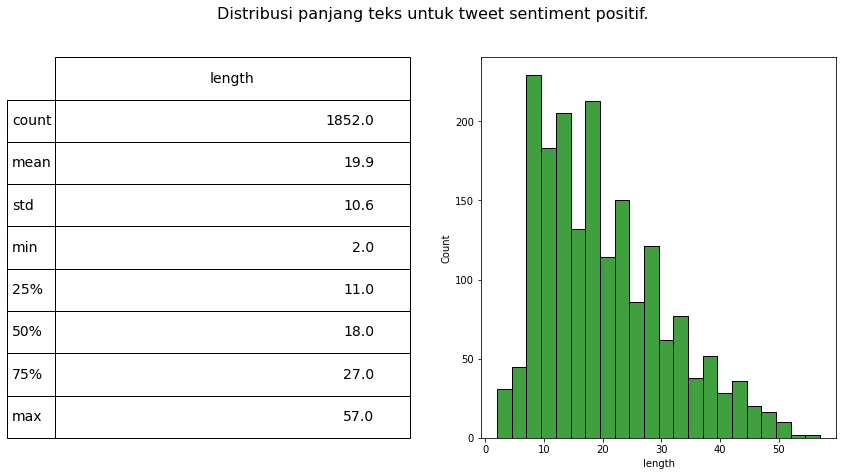

In [ ]:
# menampilkan distribusi panjang teks untuk tweet sentiment positif

fig = plt.figure(figsize=(14,7))
df['length'] = df.Sentence.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Sentiment']=='positive']['length'], ax=ax1,color='green')
describe = df.length[df.Sentiment=='positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribusi panjang teks untuk tweet sentiment positif.', fontsize=16)

plt.show()

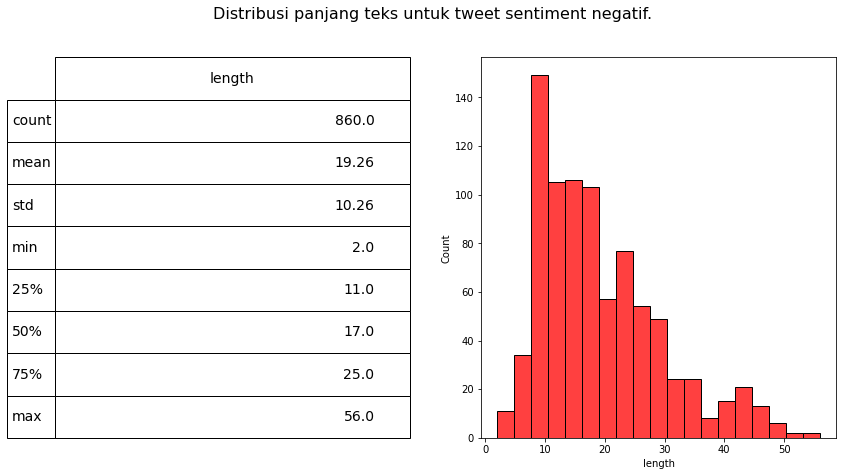

In [ ]:
# menampilkan distribusi panjang teks untuk tweet sentiment negatif

fig = plt.figure(figsize=(14,7))
df['length'] = df.Sentence.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Sentiment']=='negative']['length'], ax=ax1,color='red')
describe = df.length[df.Sentiment=='negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribusi panjang teks untuk tweet sentiment negatif.', fontsize=16)

plt.show()

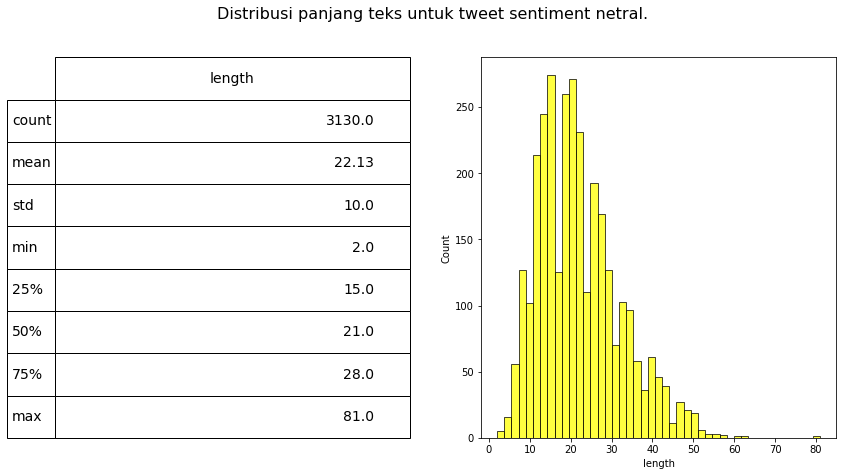

In [ ]:
# menampilkan distribusi panjang teks untuk tweet sentiment netral

fig = plt.figure(figsize=(14,7))
df['length'] = df.Sentence.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Sentiment']=='neutral']['length'], ax=ax1,color='yellow')
describe = df.length[df.Sentiment=='neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribusi panjang teks untuk tweet sentiment netral.', fontsize=16)

plt.show()

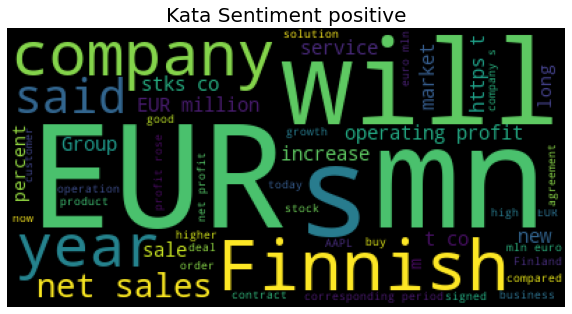

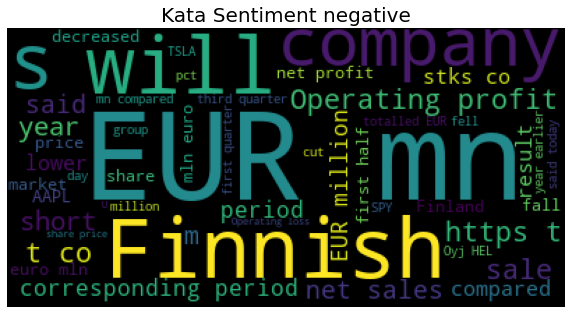

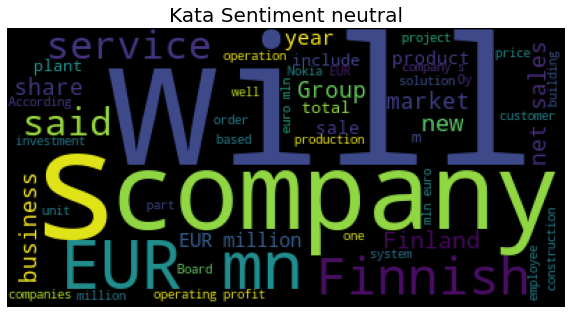

In [ ]:
# menampilkan visualisasi kata yang ada pada tweet dari dataset

def wordcount(df, Sentiment):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - Sentiment: Positive/Negative/Neutral
    '''
    # menggabungkan semua tweet
    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment==Sentiment]['Sentence']])
                          
    # inisialisasi wordcloud object
    wc = WordCloud(background_color='black', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # menampilkan plot
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('Kata Sentiment {}'.format(Sentiment), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet
wordcount(df, 'positive')
     
# Negative tweet
wordcount(df, 'negative')
     
# Neutral tweet
wordcount(df, 'neutral')

### **Data Preprocessing**

In [ ]:
def tweet_to_words(tweet):
    ''' Mengonversi teks tweet menjadi sequence of words '''
    
    # mengubah ke huruf kecil
    text = tweet.lower()
    # menghapus yang tidak termasuk huruf
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenizer
    words = text.split()
    # menghapus stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['Sentence'][0])
print("\nHasil Preprocessing tweet ->", tweet_to_words(df['Sentence'][0]))


Original tweet -> The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .

Hasil Preprocessing tweet -> ['geosolut', 'technolog', 'leverag', 'benefon', 'gp', 'solut', 'provid', 'locat', 'base', 'search', 'technolog', 'commun', 'platform', 'locat', 'relev', 'multimedia', 'content', 'new', 'power', 'commerci', 'model']


In [ ]:
# menerapkan data preprocessing ke setiap tweet pada dataset
X = list(map(tweet_to_words, df['Sentence']))

In [ ]:
# mengubah data kategorikal dari kolom sentiment menjadi numerik
le = LabelEncoder()
Y = le.fit_transform(df['Sentiment'])

In [ ]:
# menampilkan hasil data preprocessing dan label encoder

print('Tweet preprocessing : ', X[0])
print('Sentiment label encoder : ', Y[0])

Tweet preprocessing :  ['geosolut', 'technolog', 'leverag', 'benefon', 'gp', 'solut', 'provid', 'locat', 'base', 'search', 'technolog', 'commun', 'platform', 'locat', 'relev', 'multimedia', 'content', 'new', 'power', 'commerci', 'model']
Sentiment label encoder :  2


### **Train test split**

In [ ]:
# melakukan split data train dan data test pada variabel X dan y, dengan test_size=0.2, dan random_state=1

y = pd.get_dummies(df['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set : ', X_train.shape, y_train.shape)
print('Validation Set : ', X_val.shape, y_val.shape)
print('Test Set : ', X_test.shape, y_test.shape)

Train Set :  (3504, 50) (3504, 3)
Validation Set :  (1169, 50) (1169, 3)
Test Set :  (1169, 50) (1169, 3)


In [ ]:
# Bag of words (BOW) feature extraction

from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000

# Tweet telah diproses sebelumnya sehingga fungsi dummy akan diteruskan ke langkah preprocessor & tokenizer
count_vector = CountVectorizer(max_features=vocabulary_size,
                               preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

**Bag of words (BOW)** adalah metode yang digunakan dalam natural language processing (NLP) untuk mengekstrak fitur dari teks. Metode ini mengkonversi sebuah dokumen teks menjadi vektor yang menyatakan frekuensi kata-kata yang muncul dalam dokumen tersebut. BoW digunakan dalam berbagai aplikasi NLP, seperti klasifikasi teks, analisis sentimen, dan clustering teks. BoW juga digunakan dalam mesin pencari untuk mengindeks dan menemukan dokumen yang relevan dengan query pencarian.

In [ ]:
# menampilkan 200 kata dan token yang sudah dibuat
print(count_vector.get_feature_names()[0:200])

['0', '00', '000', '000063', '002', '0030', '007', '01', '0101138', '012', '0187274', '019', '02', '023', '027', '03', '030', '031', '035', '04', '045', '046', '047', '05', '050', '052', '06', '063', '067', '07', '0711', '0762', '08', '087', '089', '09', '094', '097', '0x', '1', '10', '100', '10000', '100m', '100mn', '101', '102', '1023', '103', '104', '105', '106', '107', '108', '109mn', '10d', '10mn', '10th', '11', '110', '111', '112', '113', '114', '115', '116', '117', '117mn', '118', '119', '11c', '11k8jzuzmu', '11m', '12', '120', '122', '124', '125', '127', '128', '129', '12mp', '12th', '13', '130', '131', '131000', '132', '133', '135', '137', '138', '139', '13mw', '14', '140', '141', '1411', '141mn', '143', '145', '146', '146mn', '148', '149', '14mn', '15', '150', '150mn', '152', '154', '155', '156', '157', '158', '159', '15mn', '15th', '15u', '16', '160', '161', '162', '163', '163e', '164', '1649', '165', '166', '168', '16mn', '17', '170', '172', '172p', '174', '1744900', '176',

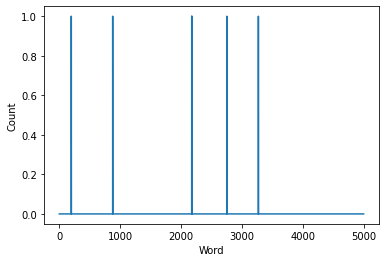

In [ ]:
# Plot the BoW feature vector

plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### **Tokenizing & Padding**

In [ ]:
# membuat tokenizer dan padding untuk mempermudah dalam modeling

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Sebelum Tokenization & Padding : \n', df['Sentence'][0])
X, tokenizer = tokenize_pad_sequences(df['Sentence'])
print('\nSetelah Tokenization & Padding : \n', X[0])

Sebelum Tokenization & Padding : 
 The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .

Setelah Tokenization & Padding : 
 [   1 3965  135   13 3127 1407   10 2008  133   18  821 1221   99 2275
  135    6 3128 1222 1221 2009 3129  682    5    6   58    5 3966  582
  474    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
# menyimpan hasil tokenizer yang sudah dibuat

import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## **Modeling**

Pada modeling ini saya menggunakan algoritma **Bidirectional LSTM**.
Karena menurut saya algoritma ini sangat cocok untuk melakukan sentiment analysis pada dataset yang digunakan.

In [ ]:
# membuat model dengan beberapa layer yang digunakan

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

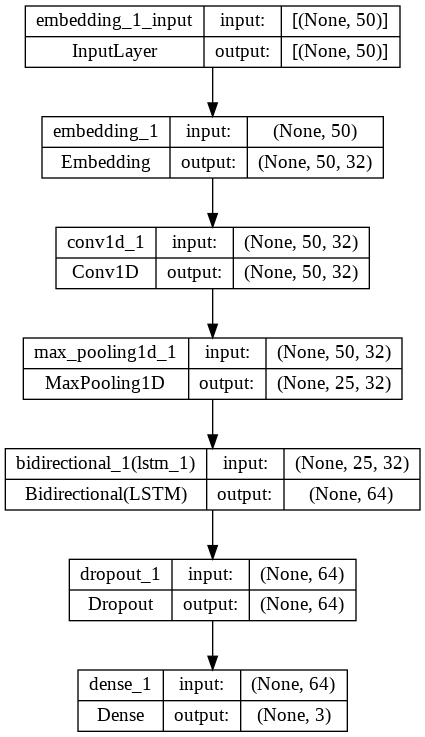

In [ ]:
# menampilkan plot hasil modeling yang dibuat

import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# melakukan train dari model yang sudah dibuat

print(model.summary())

# compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                

### **Model Accuracy and Loss**

In [ ]:
# evaluasi model pada test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6621
Precision : 0.7009
Recall    : 0.5954
F1 Score  : 0.6438


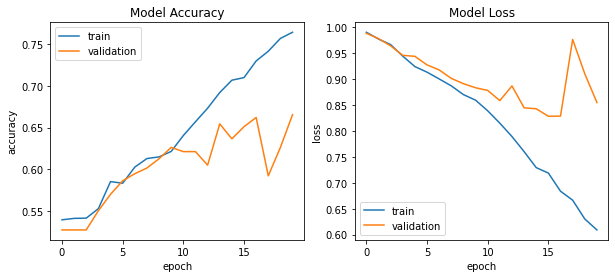

In [ ]:
# menampilkan plot hasil train model

def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [ ]:
# menyimpan hasil modeling
model.save('model_sentiment.h5')
print('Model berhasil disimpan')

Model berhasil disimpan


## **Testing model**

In [ ]:
# melakukan uji coba model yang sudah dibuat

from keras.models import load_model

# Load model
model = load_model('model_sentiment.h5')

def predict_class(text):
    '''Berfungsi untuk memprediksi kelas sentimen dari teks yang dimasukan'''
    
    sentiment_classes = ['negative', 'neutral', 'positive']
    max_len=50
    
    # Mengubah teks menjadi urutan bilangan bulat menggunakan objek tokenizer
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences dengan panjang yang sama
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Lakukan prediksi menggunakan model yang dibuat
    yt = model.predict(xt).argmax(axis=1)
    # Menampilkan prediksi
    print('Prediksi sentiment adalah', sentiment_classes[yt[0]])

In [ ]:
predict_class(['in 2023, bitcoin saw a price increase'])

1/1 [==============================] - 0s 29ms/step
Prediksi sentiment adalah positive


In [ ]:
predict_class(['this year stock price is very good'])

1/1 [==============================] - 0s 25ms/step
Prediksi sentiment adalah positive


**Kesimpulan**

Pada modeling yang sudah dibuat menggunakan algoritma Biderictional LSTM, pada dataset ini memiliki accuracy sebagai berikut :
* Accuracy  : 0.6621
* Precision : 0.7009
* Recall    : 0.5954
* F1 Score  : 0.6438

yang dimana artinya pada modeling ini masih kurang optimal untuk melakukan prediksi dikarenakan hasil dari modeling masih belum mencukupi untuk menghasilkan sebuah prediksi yang akurat. Sehingga dengan adanya kendala ini mungkin masih bisa dilakukan tuning pada model.